### Machine Learning on Twitter Text with Google NLP API
#### Dr. Elaina A. Hyde
#### Google Cloud Engineering Instructor and Trainer
#### Servian, Sydney: November 2018

In [18]:
from datalab.context import Context
import google.datalab.storage as storage
import google.datalab.bigquery as bq
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import numpy as np
import shutil
import time
from tensorflow.python.lib.io import file_io

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
APIKEY="XXXXX"

In [3]:
!pip install --upgrade google-api-python-client

    100% |████████████████████████████████| 143kB 15.2MB/s ta 0:00:01
  Running setup.py bdist_wheel for google-api-python-client ... done
  Stored in directory: /content/.cache/pip/wheels/f1/55/aa/9e8fbe2d6a43e92b3c14307194e7ff53d1ef7907613edbd661
Successfully built google-api-python-client
  Found existing installation: google-api-python-client 1.6.2
    Uninstalling google-api-python-client-1.6.2:
      Successfully uninstalled google-api-python-client-1.6.2


In [5]:
%bq tables describe --name twitter.best

In [20]:
with file_io.FileIO('gs://nlpstorage/results-20181102-141401.csv', 'r') as f:
  df=pd.read_csv(f)

In [21]:
df.head()

,tweet_timestamp,user_screen_name,tweet_text
0,2018-11-01 23:11:48.619 UTC,"""sophire2500""","""RT @shannonrwatts: Surprising no one, Shea - ..."
1,2018-11-01 23:11:48.619 UTC,"""Heather941001""","""RT @chrissyteigen: This is literally just a g..."
2,2018-11-01 23:11:48.619 UTC,"""JasperWyllie""","""@GloverKeri And who diagnosed your illness, D..."
3,2018-11-01 23:11:48.619 UTC,"""SheriBiemans""","""RT @funder: We filed a FBI complaint on Roger..."
4,2018-11-01 23:11:48.619 UTC,"""skolbowski""","""@Ejmaenner @mary_mazzerello @thebbsteve @Sena..."


In [27]:
print(df['tweet_text'][0])
print(len(df['tweet_text']))

"RT @shannonrwatts: Surprising no one, Shea - who serves on a Washington state committee with jurisdiction over most firearms legislation -…"
16000


In [38]:
rts=df[df['tweet_text'].str.match('"RT')]
print("Retweets ", len(rts['tweet_text']))
google=df[df['tweet_text'].str.contains('#Google')]
print("Google ", len(google['tweet_text']))
#another

('Retweets ', 11030)
('Google ', 582)


In [55]:
from googleapiclient.discovery import build

polarity=[]
magnitude=[]

lservice = build('language', 'v1beta1', developerKey=APIKEY)
for tweet in google['tweet_text']:
  response = lservice.documents().analyzeSentiment(
    body={
      'document': {
         'type': 'PLAIN_TEXT',
         'content': tweet
      }
    }).execute()
  polarity.append(response['documentSentiment']['polarity'])
  magnitude.append(response['documentSentiment']['magnitude'])

print(len(polarity))
#print('POLARITY=%s MAGNITUDE=%s for %s' % (polarity, magnitude, tweet))

582


In [56]:
google['polarity']=polarity
google['magnitude']=magnitude
google.head()

/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,tweet_timestamp,user_screen_name,tweet_text,datef,polarity,magnitude
32,2018-11-01 23:11:48.616 UTC,"""kamnamm""","""The #Google walkouts to their company's failu...",2018-11-01 23:11:48.616,-0.8,1.0
43,2018-11-01 23:11:48.615 UTC,"""awoobles""","""RT @ktbenner: Thousands of employees in 40+ G...",2018-11-01 23:11:48.615,1.0,0.0
74,2018-11-01 23:11:38.419 UTC,"""ZiiM84""","""RT @CB618444: #GoogleWalkout seems #Google is...",2018-11-01 23:11:38.419,-1.0,0.1
95,2018-11-01 23:11:38.401 UTC,"""gautamhathi""","""RT @kateconger: A final write-through on toda...",2018-11-01 23:11:38.401,1.0,0.0
144,2018-11-01 23:11:25.064 UTC,"""ProTouchSystems""","""How to ask your #clients for #Google #reviews...",2018-11-01 23:11:25.064,1.0,0.1


In [57]:
google['datef']=pd.to_datetime(google['tweet_timestamp'], yearfirst='TRUE')
google['datef'].head()

/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


32    2018-11-01 23:11:48.616
43    2018-11-01 23:11:48.615
74    2018-11-01 23:11:38.419
95    2018-11-01 23:11:38.401
144   2018-11-01 23:11:25.064
Name: datef, dtype: datetime64[ns]

In [83]:
#averages
polavg=np.mean(google['polarity'])
magavg=np.mean(google['magnitude'])
print('polarity', polavg, 'magnitude', magavg)

('polarity', -0.30103092783505153, 'magnitude', 0.31151202749140894)


Text(0,0.5,u'Magnitude')

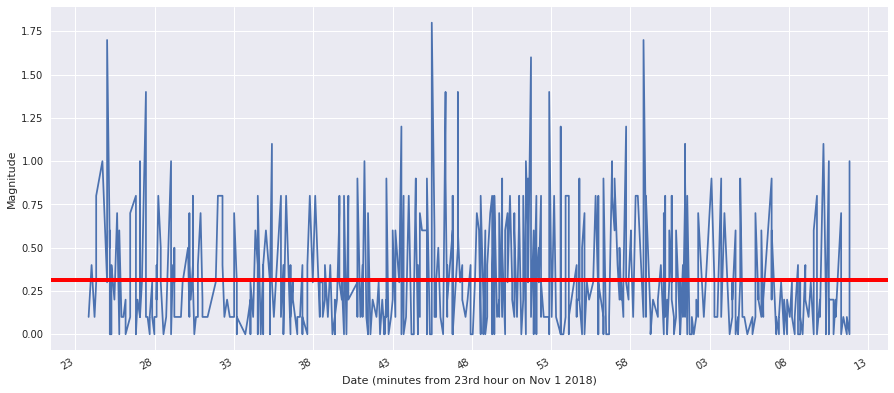

In [82]:
data = pd.concat([google['datef'], google['magnitude']], axis=1)
data.set_index('datef',inplace=True)
fig, ax = plt.subplots(figsize=(15,7))
data.plot(ax=ax, legend=False)
ax.axhline(y=magavg, linewidth=4, color='r')
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%M'))
ax.set_xlabel('Date (minutes from 23rd hour on Nov 1 2018)')
ax.set_ylabel('Magnitude')

Text(0,0.5,u'Polarity')

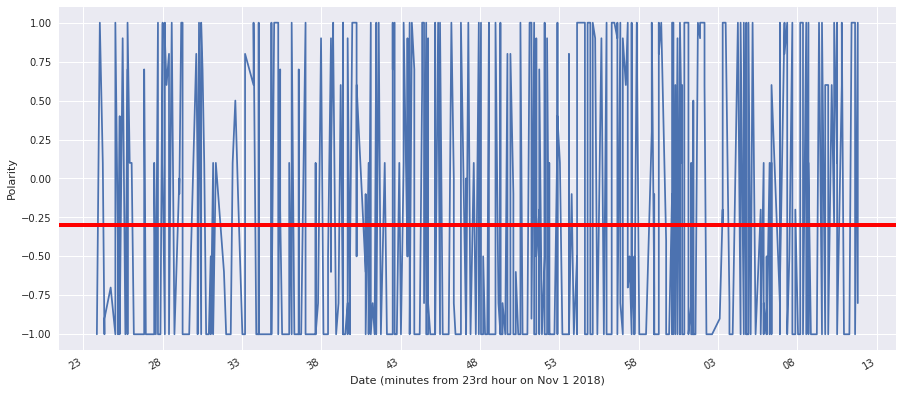

In [84]:
data2 = pd.concat([google['datef'], google['polarity']], axis=1)
data2.set_index('datef',inplace=True)
fig, ax2 = plt.subplots(figsize=(15,7))
data2.plot(ax=ax2, legend=False)
ax2.axhline(y=polavg, linewidth=4, color='r')
ax2.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%M'))
ax2.set_xlabel('Date (minutes from 23rd hour on Nov 1 2018)')
ax2.set_ylabel('Polarity')